## Infection Path Analysis Using Routes

The purpose of this notebook is to try and analyse the path of infection for COVID-19. Below is a brief description of how the algorithm works.

### Path of Infection Algorithm

1. Pick a sufficiently large threshold (infected_thresh) which indicates when a location has been infected.
2. Using time series data, add the location that first recorded infections (even if it is below the threshold).
3. If a location becomes infected and has a direct path to another location that is infected then add an edge. If it does not have a direct path to another infected location then decrease infected_thresh and go back to step 2.
4. Repeat step 3 for all the time series data. If all infected locations are added and the rule defined in step 3 is never broken and the graph contains x% of the countries that have recorded COVID-19 

In [10]:
from covid_data import CovidData
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
!{sys.executable} -m pip install ipyleaflet
!{sys.executable} -m pip install ipywidgets

In [11]:
!jupyter nbextension enable --py --sys-prefix ipyleaflet
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-leaflet/extension...
      - Validating: OK
Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [12]:
from ipyleaflet import (
    Map, basemaps, basemap_to_tiles, Circle, 
    Marker, FullScreenControl, LayersControl, 
    LayerGroup, CircleMarker, Polyline
)

In [3]:
covid_data_manager = CovidData()

bin_region_column = 'state'
covid_data, routes_data = covid_data_manager.getData(bin_region_column=bin_region_column)
data_confirmed = covid_data['confirmed']
data_confirmed

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,5/4/20,5/5/20,5/6/20,5/7/20,5/8/20,5/9/20,5/10/20,5/11/20,5/12/20,5/13/20
0,Alabama,US,32.884280,-86.710122,0,0,0,0,0,0,...,8112,8437,8691,9046,9385,9668,9889,10164,10464,10700
1,Alaska,US,60.261375,-145.838598,0,0,0,0,0,0,...,370,371,372,374,377,378,379,379,379,379
2,Alberta,Canada,53.933300,-116.576500,0,0,0,0,0,0,...,5836,5893,5963,6017,6098,6157,6253,6300,6345,6407
3,American Samoa,US,-14.271000,-170.132000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Anguilla,United Kingdom,18.220600,-63.068600,0,0,0,0,0,0,...,3,3,3,3,3,3,3,3,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
317,none,West Bank and Gaza,31.952200,35.233200,0,0,0,0,0,0,...,362,371,374,375,375,375,375,375,375,375
318,none,Western Sahara,24.215500,-12.885800,0,0,0,0,0,0,...,6,6,6,6,6,6,6,6,6,6
319,none,Yemen,15.552727,48.516388,0,0,0,0,0,0,...,12,22,25,25,34,34,51,56,65,70
320,none,Zambia,-15.416700,28.283300,0,0,0,0,0,0,...,137,138,146,153,167,252,267,267,441,446


In [4]:
def clean_data(data_confirmed):
    return data_confirmed.loc[(data_confirmed['Lat'] != 0) & (data_confirmed['Long'] != 0)]

def clean_routes(routes, bin_region_column):
    if bin_region_column == 'county':
        return routes.loc[
            (routes['DepartCounty'] != routes['ArrivalCounty']) &
            (routes['DepartProvince/State'] != routes['ArrivalProvince/State']) &
            (routes['DepartCountry/Region'] != routes['ArrivalCountry/Region'])
        ]
    elif bin_region_column == 'state':
        return routes.loc[
            (routes['DepartProvince/State'] != routes['ArrivalProvince/State']) &
            (routes['DepartCountry/Region'] != routes['ArrivalCountry/Region'])
        ]
    else:
        return routes.loc[
            (routes['DepartCountry/Region'] != routes['ArrivalCountry/Region'])
        ]
data_confirmed = clean_data(data_confirmed)
routes = clean_routes(routes_data, bin_region_column)

In [5]:
import networkx as nx

def get_initial_infect_thresh(data_confirmed, infect_percent):
    latest_date = data_confirmed.columns.tolist()[-1]
    num_of_countries = data_confirmed.shape[0]
    return data_confirmed.sort_values(latest_date).iloc[int(num_of_countries*(1-infect_percent))][latest_date]

def route_indexes_between_nodes(node_loc_0, node_loc_1, routes, bin_region_column):
        node_loc_names_0 = node_loc_0.split('-')
        node_loc_names_1 = node_loc_1.split('-')
        
        if bin_region_column == 'county':
            from_0_to_1 = ((routes['DepartCounty'] == node_loc_names_0[0]) & 
                           (routes['DepartProvince/State'] == node_loc_names_0[1]) &
                           (routes['DepartCountry/Region'] == node_loc_names_0[2]) &
                           (routes['ArrivalCounty'] == node_loc_names_1[0]) &
                           (routes['ArrivalProvince/State'] == node_loc_names_1[1]) &
                           (routes['ArrivalCountry/Region'] == node_loc_names_1[2]))
            
            from_1_to_0 = ((routes['DepartCounty'] == node_loc_names_1[0]) & 
                           (routes['DepartProvince/State'] == node_loc_names_1[1]) &
                           (routes['DepartCountry/Region'] == node_loc_names_1[2]) &
                           (routes['ArrivalCounty'] == node_loc_names_0[0]) &
                           (routes['ArrivalProvince/State'] == node_loc_names_0[1]) &
                           (routes['ArrivalCountry/Region'] == node_loc_names_0[2]))
        elif bin_region_column == 'state':
            from_0_to_1 = ((routes['DepartProvince/State'] == node_loc_names_0[0]) &
                           (routes['DepartCountry/Region'] == node_loc_names_0[1]) &
                           (routes['ArrivalProvince/State'] == node_loc_names_1[0]) &
                           (routes['ArrivalCountry/Region'] == node_loc_names_1[1]))
            
            from_1_to_0 = ((routes['DepartProvince/State'] == node_loc_names_1[0]) &
                           (routes['DepartCountry/Region'] == node_loc_names_1[1]) &
                           (routes['ArrivalProvince/State'] == node_loc_names_0[0]) &
                           (routes['ArrivalCountry/Region'] == node_loc_names_0[1]))
        else:
            from_0_to_1 = ((routes['DepartCountry/Region'] == node_loc_names_0[0]) &
                           (routes['ArrivalCountry/Region'] == node_loc_names_1[0]))
            
            from_1_to_0 = ((routes['DepartCountry/Region'] == node_loc_names_1[0]) &
                           (routes['ArrivalCountry/Region'] == node_loc_names_0[0]))
        return from_0_to_1, from_1_to_0
    
def get_cases_on_date(name_loc, data_confirmed, date, bin_region_column):
    name_loc_split = name_loc.split('-')
    if bin_region_column == 'county':
        return data_confirmed.loc[(data_confirmed['County'] == name_loc_split[0]) &
                                  (data_confirmed['Province/State'] == name_loc_split[1]) &
                                  (data_confirmed['Country/Region'] == name_loc_split[2])][date]
    elif bin_region_column == 'state':
        return data_confirmed.loc[(data_confirmed['Province/State'] == name_loc_split[0]) &
                                  (data_confirmed['Country/Region'] == name_loc_split[1])][date]
    else:
        return data_confirmed.loc[(data_confirmed['Country/Region'] == name_loc_split[0])][date]
    
def get_dates(data_confirmed, bin_region_column):
    if bin_region_column == 'county':
        return data_confirmed.columns.tolist()[5:]
    if bin_region_column == 'state':
        return data_confirmed.columns.tolist()[4:]
    if bin_region_column == 'country':
        return data_confirmed.columns.tolist()[3:]

def get_infection_path(data_confirmed, routes, infect_thresh, bin_region_column):
    def get_loc_name(df_row, bin_region_column=bin_region_column):
        if bin_region_column == 'county':
            return "{}-{}-{}".format(df_row['County'], df_row['Province/State'], df_row['Country/Region'])
        elif bin_region_column == 'state':
            return "{}-{}".format(df_row['Province/State'], df_row['Country/Region'])
        elif bin_region_column == 'country':
            return "{}".format(df_row['Country/Region'])
        return None
    
    def get_initial_case(data_confirmed, dates):
        first_date = dates[0]
        return data_confirmed.sort_values(first_date).iloc[-1]
    
    infect_graph = nx.Graph()
    dates = get_dates(data_confirmed, bin_region_column)
    case_zero = get_initial_case(data_confirmed, dates)
    case_zero_name = get_loc_name(case_zero)
    infect_graph.add_node(case_zero_name)
    location_pos = {case_zero_name : (case_zero['Lat'], case_zero['Long'])}
    infect_graphs = {}
    max_confirmed = {}
    infected_parents = {case_zero_name : []}

    for date in dates:
        conf_sort_day =  data_confirmed.sort_values(date).loc[data_confirmed[date] >= infect_thresh]
        try:
            max_confirmed[date] = conf_sort_day.iloc[-1][date]
        except:
            max_confirmed[date] = case_zero[date]
        
        for _index, row in conf_sort_day.iterrows():
            node_loc = get_loc_name(row)
            
            if not infect_graph.has_node(node_loc):
                already_infected = infect_graph.nodes
                coords = (row['Lat'], row['Long'])
                infect_graph.add_node(node_loc, pos=coords)
                infected_parents[node_loc] = []
                location_pos[node_loc] = coords
                # connect_to_infect = False - eventually for getting a connected graph
                
                for infected in already_infected:
                    from_infected_to_loc, from_loc_to_infected = route_indexes_between_nodes(infected, node_loc, routes, bin_region_column)
                    
                    if routes.loc[from_infected_to_loc].shape[0] > 0 or routes.loc[from_loc_to_infected].shape[0] > 0:
                        infect_graph.add_edge(infected, node_loc)
                        
                    if routes.loc[from_infected_to_loc].shape[0] > 0:
                        infected_parents[infected] = infected_parents[infected] + [node_loc]
                
        infect_graphs[date] = infect_graph.copy()
        
    return infect_graphs, location_pos, max_confirmed, infected_parents

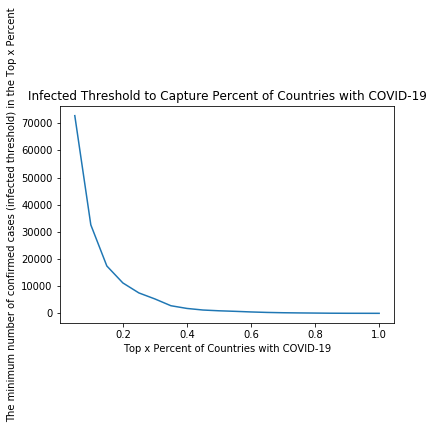

In [6]:
plt.plot([xx for xx in np.arange(0.05, 1.05, 0.05)], 
         [ get_initial_infect_thresh(data_confirmed, xx) for xx in np.arange(0.05, 1.05, 0.05)])
plt.title("Infected Threshold to Capture Percent of Countries with COVID-19")
plt.xlabel("Top x Percent of Countries with COVID-19")
plt.ylabel("The minimum number of confirmed cases (infected threshold) in the Top x Percent")
plt.show()

In [7]:
infect_thresh = get_initial_infect_thresh(data_confirmed, 0.2)
print("INITIAL INFECTION THRESHOLD SET TO {}".format(infect_thresh))
infect_graphs, location_pos, max_confirmed, infected_parents = get_infection_path(data_confirmed, routes, infect_thresh, bin_region_column)

INITIAL INFECTION THRESHOLD SET TO 11196


In [8]:
def generate_graph(infect_graphs, location_pos, max_confirmed, data_confirmed, date, bin_region_column, scale=3):
    infect_graph = infect_graphs[date]
    max_confirm = max_confirmed[date]
    
    marker_layer = LayerGroup(name='markers')
    circle_layer = LayerGroup(name='circles')
    
    for name_loc in infect_graph.nodes:
        marker = Marker(location=location_pos[name_loc], draggable=False, title=name_loc, opacity=0)
        marker_layer.add_layer(marker)
        
        circle = Circle(location=location_pos[name_loc], 
                        radius=int(get_cases_on_date(name_loc, data_confirmed, date, bin_region_column)*scale),#/max_confirm*scale),
                        color = 'red', fill_color = 'red')
        circle_layer.add_layer(circle)
    
    return marker_layer, circle_layer
    
def generate_routes(infect_graphs, location_pos, routes_df, date, bin_region_column):
    infect_graph = infect_graphs[date]
    max_route = max(routes['NumberOfRoutes'])
    line_layer = LayerGroup(name='Lines')
    for c1, c2 in infect_graph.edges:
        c1_to_c2_bool_map, c2_to_c1_bool_map = route_indexes_between_nodes(c1, c2, routes, bin_region_column)
        try:
            c1_to_c2 = routes.loc[c1_to_c2_bool_map]['NumberOfRoutes'].tolist()[0]
        except:
            c1_to_c2 = 0
        try:
            c2_to_c1 = routes.loc[c2_to_c1_bool_map]['NumberOfRoutes'].tolist()[0]
        except:
            c2_to_c1 = 0
        routes_between = c1_to_c2 if c1_to_c2 > c2_to_c1 else c2_to_c1
        line = Polyline(locations=[location_pos[c1], location_pos[c2]], color='blue', opacity=routes_between/max_route)
        line_layer.add_layer(line)
        
    return line_layer

In [13]:
DATE = '4/2/20'

infection_map = Map(basemap=basemaps.OpenStreetMap.Mapnik, center=(0,0), zoom=1)
infection_map.add_control(FullScreenControl())
marker_layer, circle_layer = generate_graph(infect_graphs, location_pos, max_confirmed, data_confirmed, DATE, bin_region_column)
line_layer = generate_routes(infect_graphs, location_pos, routes, DATE, bin_region_column)

infection_map.add_layer(marker_layer)
infection_map.add_layer(circle_layer)
infection_map.add_layer(line_layer)

In [14]:
infection_map

Map(center=[0, 0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text'…

# DO NO RUN IT IS EXTREMELY SLOW ATM! FIXING UP

In [285]:
time_infection_map = Map(basemap=basemaps.OpenStreetMap.Mapnik, center=(0,0), zoom=1)
infection_map.add_control(FullScreenControl())
time_infection_map

Map(center=[0, 0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text'…

In [ ]:
import time

def display_infection_graph_time(infect_graphs, location_pos, max_confirmed, data_confirmed, 
                                 routes, infection_map, dates, bin_region_column):
    prev_marker_layer, prev_circle_layer, prev_line_layer = None, None, None
    for date in dates:
        marker_layer, circle_layer = generate_graph(infect_graphs, location_pos, max_confirmed, 
                                                    data_confirmed, date, bin_region_column,scale=3)
        line_layer = generate_routes(infect_graphs, location_pos, routes, date, bin_region_column)
        
        infection_map.add_layer(marker_layer)
        infection_map.add_layer(circle_layer)
        infection_map.add_layer(line_layer)
        time.sleep(0.5)
        
        if not prev_marker_layer == None:
            infection_map.remove_layer(prev_marker_layer)
            infection_map.remove_layer(prev_circle_layer)
            infection_map.remove_layer(prev_line_layer)
        
        time.sleep(0.5)
        prev_marker_layer, prev_circle_layer, prev_line_layer = marker_layer, circle_layer, line_layer

dates = get_dates(data_confirmed, bin_region_column)
display_infection_graph_time(infect_graphs, location_pos, max_confirmed, data_confirmed, 
                             routes, time_infection_map, dates, bin_region_column)

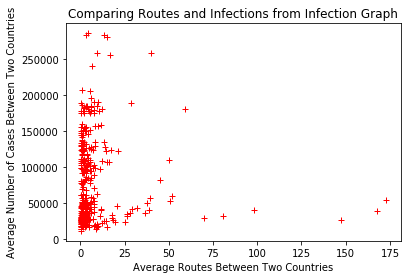

In [148]:
import matplotlib.pyplot as plt
def plot_latest_routes_to_cases(infect_graphs, routes, data_confirmed):
    latest_date = data_confirmed.columns[-1]
    infect_graph = infect_graphs[latest_date]
    
    avg_routes_between = []
    avg_cases_between = []
    for c1, c2 in infect_graph.edges:
        c1_to_c2_bool_map, c2_to_c1_bool_map = route_indexes_between_nodes(c1, c2, routes, bin_region_column)
        try:
            c1_to_c2 = routes.loc[c1_to_c2_bool_map]['NumberOfRoutes'].tolist()[0]
        except:
            c1_to_c2 = 0
        try:
            c2_to_c1 = routes.loc[c2_to_c1_bool_map]['NumberOfRoutes'].tolist()[0]
        except:
            c2_to_c1 = 0
        
        avg_r_between = (c1_to_c2 + c2_to_c1)/2
        c1_cases = get_cases_on_date(c1, data_confirmed, latest_date, bin_region_column).tolist()[0]
        c2_cases = get_cases_on_date(c2, data_confirmed, latest_date, bin_region_column).tolist()[0]
        avg_cases = (c1_cases + c2_cases)/2
#         if avg_cases > 1000000:
#             print("HIGHEST AVERAGE BETWEEN LOCATIONS {} AND {} IS {}".format(c1, c2, avg_cases))
#             #continue
#         if avg_cases > 500000:
#             print("HIGH AVERAGE BETWEEN LOCATIONS {} AND {} IS {}".format(c1, c2, avg_cases))
#             #continue
        
        avg_routes_between.append(avg_r_between)
        avg_cases_between.append(avg_cases)
        
    plt.plot(avg_routes_between, avg_cases_between, 'r+')
    plt.title("Comparing Routes and Infections from Infection Graph")
    plt.xlabel("Average Routes Between Two Countries")
    plt.ylabel("Average Number of Cases Between Two Countries")
        
plot_latest_routes_to_cases(infect_graphs, routes, data_confirmed)

In [173]:
infected_parents

{'Hubei-China': ['none-Italy',
  'none-France',
  'California-US',
  'none-Japan',
  'none-Singapore',
  'none-United Arab Emirates',
  'none-Indonesia',
  'none-Korea, South'],
 'none-Italy': ['New York-US',
  'New Jersey-US',
  'California-US',
  'Michigan-US',
  'Massachusetts-US',
  'Florida-US',
  'Illinois-US',
  'Pennsylvania-US',
  'Georgia-US',
  'Ontario-Canada',
  'Virginia-US',
  'North Carolina-US',
  'Minnesota-US'],
 'none-Iran': ['Minnesota-US'],
 'none-Spain': ['New York-US',
  'New Jersey-US',
  'California-US',
  'Massachusetts-US',
  'Florida-US',
  'Illinois-US',
  'Texas-US',
  'Ontario-Canada',
  'Virginia-US',
  'North Carolina-US'],
 'none-Germany': ['New York-US',
  'New Jersey-US',
  'California-US',
  'Michigan-US',
  'Massachusetts-US',
  'Florida-US',
  'Illinois-US',
  'Pennsylvania-US',
  'Texas-US',
  'Georgia-US',
  'Washington-US',
  'Maryland-US',
  'Ontario-Canada',
  'Virginia-US',
  'Colorado-US',
  'North Carolina-US',
  'Arizona-US',
  'Minnesot

In [17]:
routes.loc[(routes["DepartCountry/Region"] == "United Kingdom")]

,DepartProvince/State,DepartCountry/Region,ArrivalProvince/State,ArrivalCountry/Region,NumberOfRoutes
120,Anguilla,United Kingdom,Puerto Rico,US,13
121,Anguilla,United Kingdom,Saint Barthelemy,France,1
122,Anguilla,United Kingdom,Sint Maarten,Netherlands,5
123,Anguilla,United Kingdom,Virgin Islands,US,3
124,Anguilla,United Kingdom,none,Antigua and Barbuda,2
...,...,...,...,...,...
9766,none,United Kingdom,Sichuan,China,1
9767,none,United Kingdom,Texas,US,12
9768,none,United Kingdom,Utah,US,1
9769,none,United Kingdom,Virginia,US,9
